### Choosing the Right Metric


<center>
    <img src = 'images/uci_biz.png'/>
</center>


This module introduced both the K Nearest Neighbors model as well as a variety of different metrics for classification.  It is important to select and understand the appropriate metric for your task.  This exercise is meant to get practice considering the difference between these new classification metrics and accompanying evaluation tools. Specifically, explore datasets related to business from the UCI Machine Learning Repository [here](https://archive-beta.ics.uci.edu/ml/datasets?f%5Barea%5D%5B0%5D=business&p%5Boffset%5D=0&p%5Blimit%5D=10&p%5BorderBy%5D=NumHits&p%5Border%5D=desc&p%5BStatus%5D=APPROVED).  

Select a dataset of interest and clearly state the classification task.  Specifically, describe a business problem that could be solved using the dataset and a KNN classification model.  Further, identify what you believe to be the appropriate metric and justify your choice.  Build a basic model with the `KNearestNeighbor` and grid search to optimize towards your chosen metric.  Share your results with your peers.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, \
                            accuracy_score, recall_score, precision_score, precision_recall_curve
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config

# Blood Transfusion Service Center Dataset
This is a donor dataset who donated blood over time per "Blood Transfusion Service Center" where a bus visits a university for blood drive in Hsin-Chu City in Taiwan every 3 months.

## Source
[Dataset found on UCI Machine Learning Repository:](https://archive-beta.ics.uci.edu/ml/datasets/blood+transfusion+service+center)

Given is the variable name, variable type, the measurement unit and a brief description. The "Blood Transfusion Service Center" is a classification problem. The order of this listing corresponds to the order of numerals along the rows of the database. R (Recency - months since last donation), F (Frequency - total number of donation), M (Monetary - total blood donated in c.c.), T (Time - months since first donation), and a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood). Table 1 shows the descriptive statistics of the data. We selected 500 data at random as the training set, and the rest 248 as the testing set. Table 1. Descriptive statistics of the data Variable Data Type Measurement Description min max mean std Recency quantitative Months Input 0.03 74.4 9.74 8.07 Frequency quantitative Times Input 1 50 5.51 5.84 Monetary quantitative c.c. blood Input 250 12500 1378.68 1459.83 Time quantitative Months Input 2.27 98.3 34.42 24.32 Whether he/she donated blood in March 2007 binary 1=yes 0=no Output 0 1 1 (24%) 0 (76%)

## Additional Information

To demonstrate the RFMTC marketing model (a modified version of RFM), this study adopted the donor database of Blood Transfusion Service Center in Hsin-Chu City in Taiwan. The center passes their blood transfusion service bus to one university in Hsin-Chu City to gather blood donated about every three months. To build a FRMTC model, we selected 748 donors at random from the donor database. These 748 donor data, each one included R (Recency - months since last donation), F (Frequency - total number of donation), M (Monetary - total blood donated in c.c.), T (Time - months since first donation), and a binary variable representing whether he/she donated blood in March 2007 (1 stand for donating blood; 0 stands for not donating blood).

Columns renamed for readability as:
+ last  : time in months since last donation
+ times : number of blood donations
+ unit  : accumulated unit of blood donations in cc
+ since : time in months since first donation
+ donated : whether donated during bus visit in March 2007 (1/0)


## Data Preparation
Read dataset and cleanup if any

In [2]:
set_config("figure")

In [3]:
blood = pd.read_csv('data/transfusion.data')

In [4]:
blood

,last,times,unit,since,donated
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [5]:
blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   last     748 non-null    int64
 1   times    748 non-null    int64
 2   unit     748 non-null    int64
 3   since    748 non-null    int64
 4   donated  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


In [6]:
blood.describe()

,last,times,unit,since,donated
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


array([[<AxesSubplot:title={'center':'last'}>,
        <AxesSubplot:title={'center':'times'}>],
       [<AxesSubplot:title={'center':'unit'}>,
        <AxesSubplot:title={'center':'since'}>],
       [<AxesSubplot:title={'center':'donated'}>, <AxesSubplot:>]],
      dtype=object)

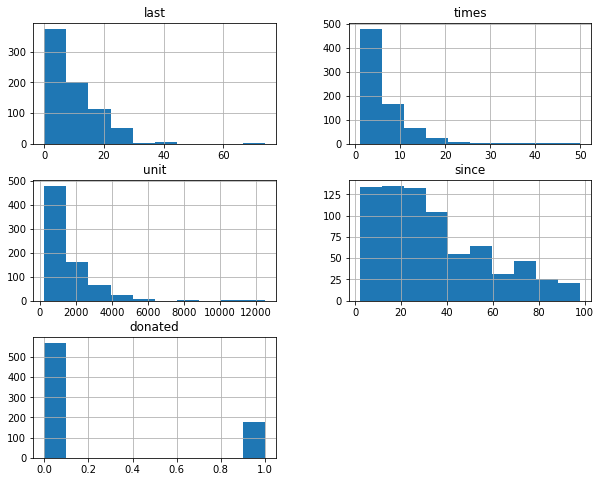

In [7]:
# histograms
blood.hist(figsize = (10, 8))

<AxesSubplot:>

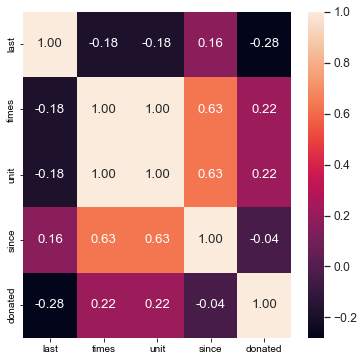

In [8]:
#heatmap
plt.subplots(figsize=(6,6))
sns.set(font_scale=1.1)
sns.heatmap(blood.corr(), annot=True, fmt='.2f')

There is a high positive correlation between `times` and `unit`, we can drop `unit`, there is also an expected correlation between since the first visit and number of blood donations as reflected in the dataset!

In [9]:
# drop unit since it is correlated with times
blood = blood.drop(['unit', 'since'], axis=1)

<AxesSubplot:>

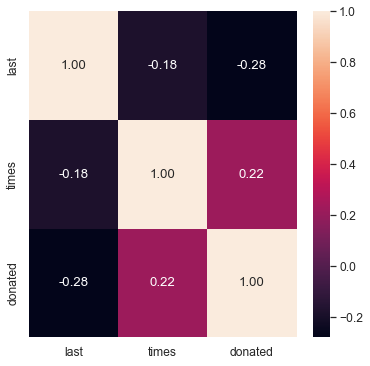

In [10]:
#heatmap after cleanup
plt.subplots(figsize=(6,6))
sns.set(font_scale=1.1)
sns.heatmap(blood.corr(), annot=True, fmt='.2f')

### Baseline Data

In [11]:
blood.donated.value_counts(normalize = True)

0    0.762032
1    0.237968
Name: donated, dtype: float64

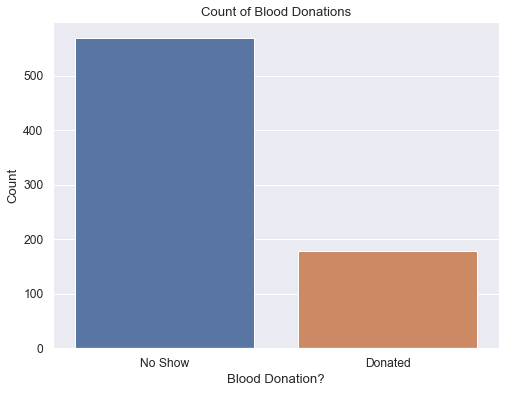

In [12]:
plt.subplots(figsize=(8,6))
splot = sns.countplot(data=blood, x = 'donated')
splot.set_xticklabels(['No Show', 'Donated'])
plt.xlabel('Blood Donation?')
plt.ylabel('Count')
plt.title('Count of Blood Donations')
plt.show()

In [13]:
blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   last     748 non-null    int64
 1   times    748 non-null    int64
 2   donated  748 non-null    int64
dtypes: int64(3)
memory usage: 17.7 KB


In [14]:
blood.columns

Index(['last', 'times', 'donated'], dtype='object')

In [15]:
blood.groupby(['last', 'times', 'donated']).size()

last  times  donated
0     2      0          1
      3      0          1
      8      0          1
      13     1          1
      26     1          1
                       ..
38    1      0          2
39    1      0          1
40    1      0          1
72    1      0          1
74    1      0          1
Length: 236, dtype: int64

<AxesSubplot:xlabel='last', ylabel='times'>

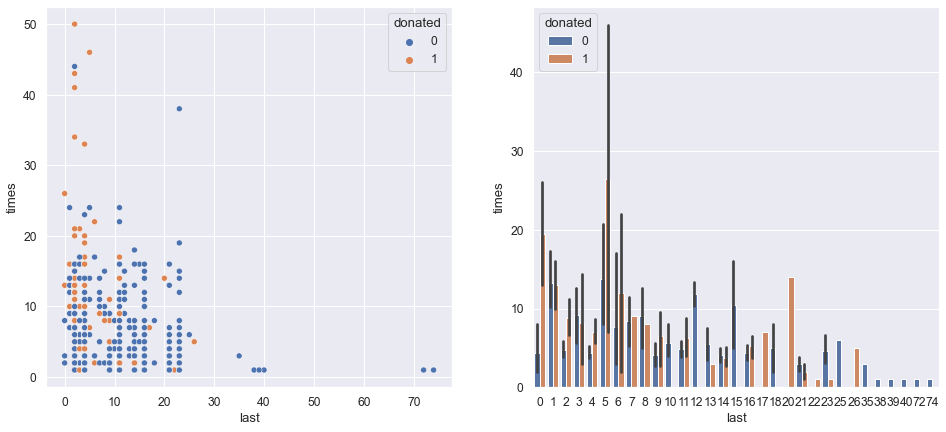

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16,7))
sns.scatterplot(data=blood, x='last', y='times', hue='donated', ax=ax[0])
sns.barplot(data=blood, x='last', y='times', hue='donated', ax=ax[1])


<AxesSubplot:xlabel='last', ylabel='times'>

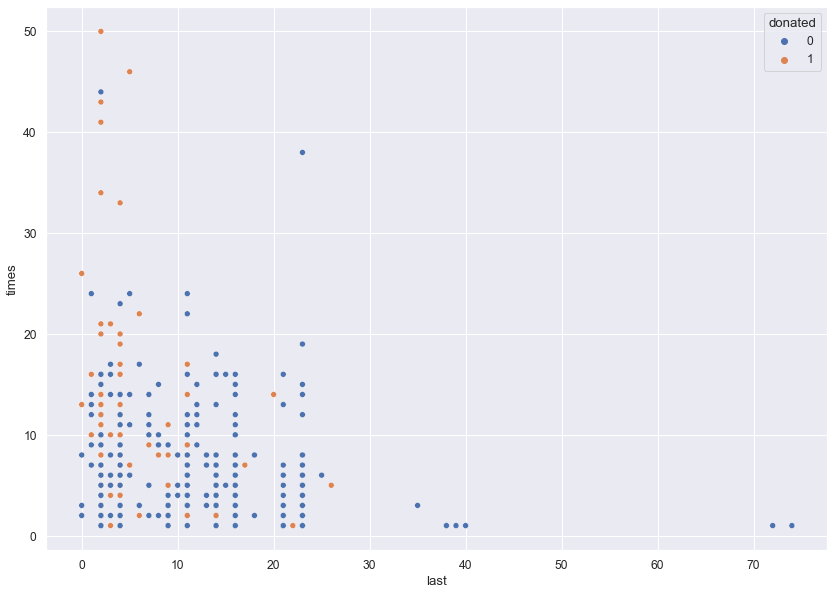

In [17]:
plt.subplots(figsize=(14,10))
sns.scatterplot(data=blood, x='last', y='times', hue='donated')

# Modeling

In [18]:
# separate features from target and split training and test datasets
X, y = blood.drop('donated', axis = 1), blood.donated
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 93, stratify = y)

In [19]:
y_train.shape, y_test.shape

((561,), (187,))

In [20]:
y_train.value_counts(normalize = True)

0    0.762923
1    0.237077
Name: donated, dtype: float64

In [21]:
y_test.value_counts(normalize = True)

0    0.759358
1    0.240642
Name: donated, dtype: float64

In [22]:
# since there is no aplhanumeric columns, we can just scale and classify data, no transformation needed
# n_neighbors=5 by default!
blood_pipeline = Pipeline([('scale', StandardScaler()),
                           ('knn', KNeighborsClassifier())])
blood_pipeline.fit(X_train, y_train)
blood_preds = blood_pipeline.predict(X_test)
blood_proba = blood_pipeline.predict_proba(X_test)

In [23]:
# adjust decision boundary
thresholds = np.arange(0, 1, .1)

In [24]:
# auc decision boundary
blood_db = pd.DataFrame(
    {'threshold':thresholds,
     'accuracy' :[accuracy_score(y_test, np.where(blood_proba[:, 1] >= t, 1, 0) ) for t in thresholds],
     'precision':[precision_score(y_test, np.where(blood_proba[:, 1] >= t, 1, 0),
                                  pos_label=1, zero_division=0) for t in thresholds],
     'recall'   :[recall_score(y_test, np.where(blood_proba[:, 1] >= t, 1, 0),
                               pos_label=1, zero_division=0) for t in thresholds]
    })

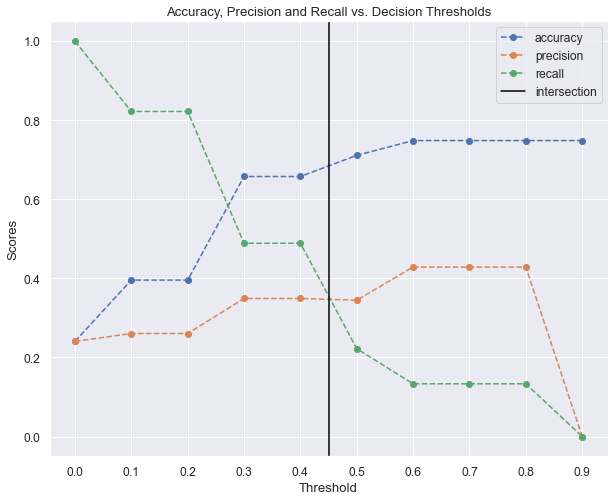

In [25]:
plt.subplots(figsize=(10,8))
plt.plot(blood_db['threshold'], blood_db['accuracy'], '--o', label = 'accuracy')
plt.plot(blood_db['threshold'], blood_db['precision'], '--o', label = 'precision')
plt.plot(blood_db['threshold'], blood_db['recall'], '--o', label = 'recall')
plt.axvline(x=0.45, color="black", label = 'intersection')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Accuracy, Precision and Recall vs. Decision Thresholds')
plt.legend()
plt.grid(True)

[0.  0.2 0.4 0.6 0.8]


Text(0.5, 1.0, 'Precision vs Recall')

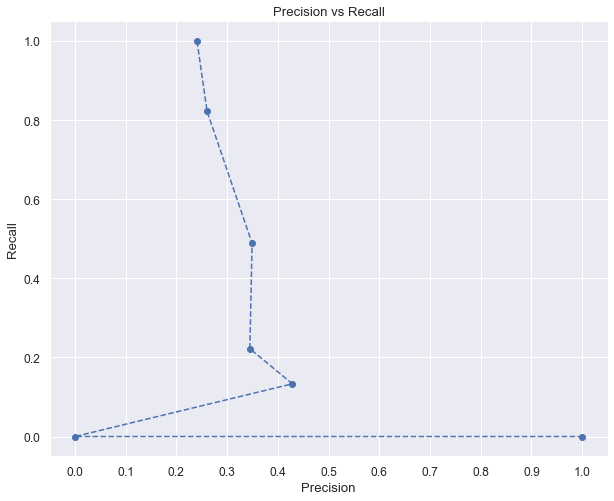

In [26]:
# Precision vs Recall
precision, recall, boundaries = precision_recall_curve(y_true = y_test,
                                                       probas_pred=blood_proba[:, 1], pos_label=1)
# 
print(boundaries[:5])
plt.subplots(figsize=(10,8))
plt.plot(precision, recall, '--o')
plt.xticks(np.arange(0, 1.1, .1))
plt.grid(True)
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall')

In [27]:
# adjust decision boundary!
low_preds = np.where(blood_proba[:, 1] > .45, 1, 0)
high_preds = np.where(blood_proba[:, 1] > .6, 1, 0)

print(sum((~low_preds) & y_test), sum(~blood_preds & y_test), sum(~high_preds & y_test))

35 35 39


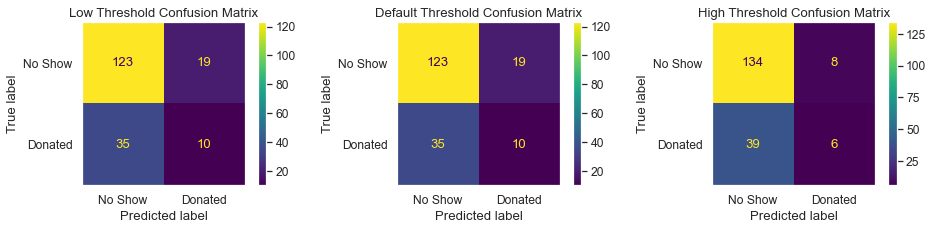

In [28]:
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, low_preds, display_labels = ['No Show', 'Donated'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, blood_preds, display_labels = ['No Show', 'Donated'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, high_preds, display_labels = ['No Show', 'Donated'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Low Threshold Confusion Matrix')
ax[1].set_title('Default Threshold Confusion Matrix')
ax[2].set_title('High Threshold Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Partial Dependence Plots for 2 Features')

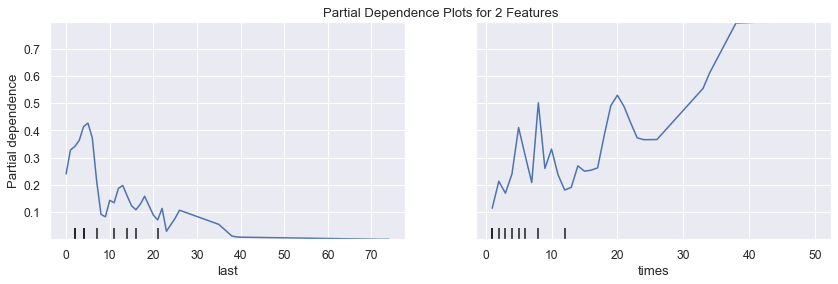

In [29]:
# Partial Dependence Plots
fig, ax = plt.subplots(figsize = (14, 4))
PartialDependenceDisplay.from_estimator(blood_pipeline, X,
                                        features = X.columns, ax = ax)
ax.set_title(f'Partial Dependence Plots for {len(X.columns)} Features')

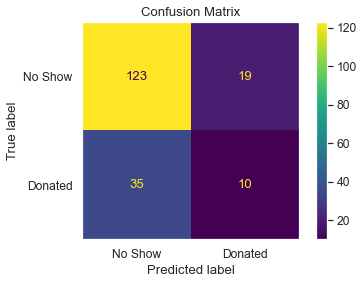

In [30]:
# blood_confusion_mat = confusion_matrix(y_test, blood_preds, labels=blood_pipeline.classes_)
# cplot = ConfusionMatrixDisplay(confusion_matrix=blood_confusion_mat, display_labels = ['No', 'Yes'])
# cplot.plot()
# plt.show()
ConfusionMatrixDisplay.from_predictions(y_test, blood_preds, display_labels = ['No Show', 'Donated'])
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

In [31]:
""" Fine tune the model with 3 different techniques:
In GridSearchCV, find best hyperparameters:
'n_neighbors': range(1, len(y_test), 2),
'weights': ['uniform', 'distance']
'scoring': accuracy, precision, recall, 'roc_auc'
{'knn__n_neighbors': 17, 'knn__weights': 'uniform'}
Best runs:
accuracy: {'knn__n_neighbors': 17, 'knn__weights': 'uniform'}
precision: {'knn__n_neighbors': 71, 'knn__weights': 'uniform'}
recall: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
roc_auc: {'knn__n_neighbors': 47, 'knn__weights': 'uniform'}
Finally, try adjusting the decision boundary from 50% - in next cells
"""
params = {'knn__n_neighbors': range(1, len(y_test), 2), 'knn__weights':['uniform', 'distance']}
for scorer in ['accuracy', 'precision', 'recall', 'roc_auc']:
    knn_grid = GridSearchCV(blood_pipeline, param_grid = params, scoring=scorer)
    knn_grid.fit(X_train, y_train)
    best_k = knn_grid.best_params_
    print(scorer + ':', best_k)

accuracy: {'knn__n_neighbors': 79, 'knn__weights': 'uniform'}


/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Applications/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318

precision: {'knn__n_neighbors': 17, 'knn__weights': 'uniform'}
recall: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
roc_auc: {'knn__n_neighbors': 181, 'knn__weights': 'uniform'}


### Receiver Operating Characteristic (ROC) Area Under Curve (AUC)

In [32]:
# go with roc_auc
auc_pipeline = Pipeline([('scale', StandardScaler()),
                         ('knn', KNeighborsClassifier(n_neighbors = 47, weights = 'uniform'))])
auc_pipeline.fit(X_train, y_train)
auc_preds = auc_pipeline.predict(X_test)
auc_proba = auc_pipeline.predict_proba(X_test)

In [33]:
# ConfusionMatrixDisplay.from_predictions(y_test, auc_preds, display_labels = ['No Show', 'Donated'])
# plt.title('Confusion Matrix')
# plt.grid(False)
# plt.show()

In [34]:
# # adjust decision boundary
# thresholds = np.arange(0, 1, .1)

In [35]:
# auc decision boundary
auc_db = pd.DataFrame(
    {'threshold':thresholds,
     'accuracy' :[accuracy_score(y_test, np.where(auc_proba[:, 1] >= t, 1, 0) ) for t in thresholds],
     'precision':[precision_score(y_test, np.where(auc_proba[:, 1] >= t, 1, 0),
                                  pos_label=1, zero_division=0) for t in thresholds],
     'recall'   :[recall_score(y_test, np.where(auc_proba[:, 1] >= t, 1, 0),
                               pos_label=1, zero_division=0) for t in thresholds]
    })

In [36]:
auc_db

,threshold,accuracy,precision,recall
0,0.0,0.240642,0.240642,1.000000
1,0.1,0.374332,0.275000,0.977778
2,0.2,0.598930,0.355769,0.822222
3,0.3,0.721925,0.442623,0.600000
4,0.4,0.737968,0.456522,0.466667
5,0.5,0.743316,0.285714,0.044444
6,0.6,0.759358,0.000000,0.000000
7,0.7,0.759358,0.000000,0.000000
8,0.8,0.759358,0.000000,0.000000
9,0.9,0.759358,0.000000,0.000000


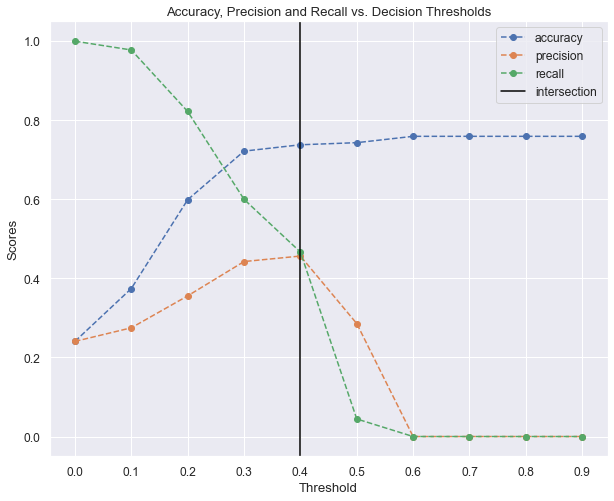

In [37]:
plt.subplots(figsize=(10,8))
plt.plot(auc_db['threshold'], auc_db['accuracy'], '--o', label = 'accuracy')
plt.plot(auc_db['threshold'], auc_db['precision'], '--o', label = 'precision')
plt.plot(auc_db['threshold'], auc_db['recall'], '--o', label = 'recall')
plt.axvline(x=0.4, color="black", label = 'intersection')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Accuracy, Precision and Recall vs. Decision Thresholds')
plt.legend()
plt.grid(True)

[0.08510638 0.10638298 0.12765957 0.14893617 0.17021277]


Text(0.5, 1.0, 'Precision vs Recall')

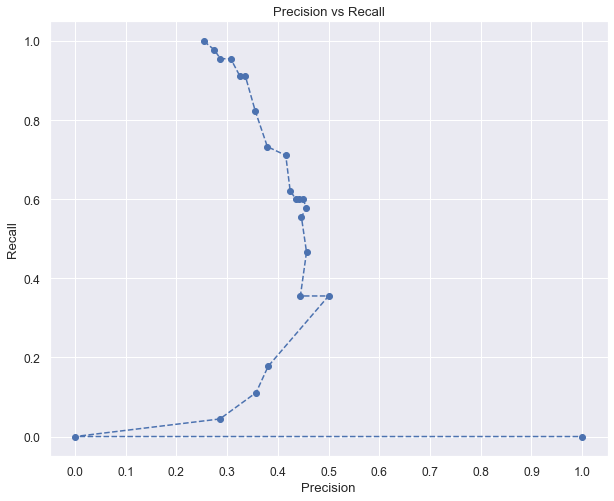

In [68]:
# Precision vs Recall
precision, recall, boundaries = precision_recall_curve(y_true = y_test,
                                                       probas_pred=auc_proba[:, 1], pos_label=1)

# plot
plt.subplots(figsize=(10,8))
plt.plot(precision, recall, '--o')
plt.xticks(np.arange(0, 1.1, .1))
plt.grid(True)
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall')

In [69]:
precision

array([0.25423729, 0.275     , 0.28666667, 0.30714286, 0.32539683,
       0.33606557, 0.35576923, 0.37931034, 0.41558442, 0.42424242,
       0.43548387, 0.44262295, 0.45      , 0.45614035, 0.44642857,
       0.45652174, 0.44444444, 0.5       , 0.38095238, 0.35714286,
       0.28571429, 0.        , 1.        ])

In [70]:
recall

array([1.        , 0.97777778, 0.95555556, 0.95555556, 0.91111111,
       0.91111111, 0.82222222, 0.73333333, 0.71111111, 0.62222222,
       0.6       , 0.6       , 0.6       , 0.57777778, 0.55555556,
       0.46666667, 0.35555556, 0.35555556, 0.17777778, 0.11111111,
       0.04444444, 0.        , 0.        ])

In [39]:
# adjust decision boundary
low_preds = np.where(auc_proba[:, 1] > .4, 1, 0)
high_preds = np.where(auc_proba[:, 1] > .6, 1, 0)

print(sum((~low_preds) & y_test), sum(~auc_preds & y_test), sum(~high_preds & y_test))

24 43 45


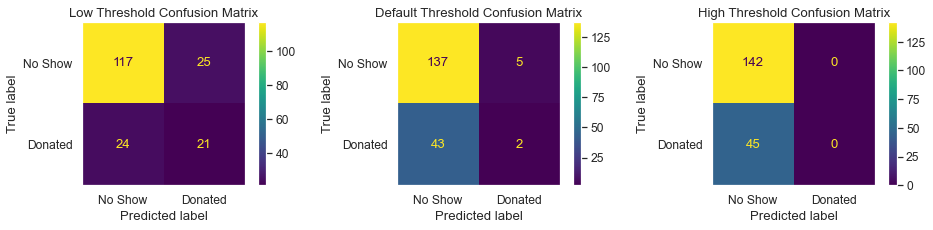

In [40]:
# plot confusion matrices
fig, ax = plt.subplots(1, 3, figsize = (16, 3))
ConfusionMatrixDisplay.from_predictions(y_test, low_preds, display_labels = ['No Show', 'Donated'], ax = ax[0])
ConfusionMatrixDisplay.from_predictions(y_test, auc_preds, display_labels = ['No Show', 'Donated'], ax = ax[1])
ConfusionMatrixDisplay.from_predictions(y_test, high_preds, display_labels = ['No Show', 'Donated'], ax = ax[2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_title('Low Threshold Confusion Matrix')
ax[1].set_title('Default Threshold Confusion Matrix')
ax[2].set_title('High Threshold Confusion Matrix')
plt.show()

Text(0.5, 1.0, 'Partial Dependence Plots for 2 Features')

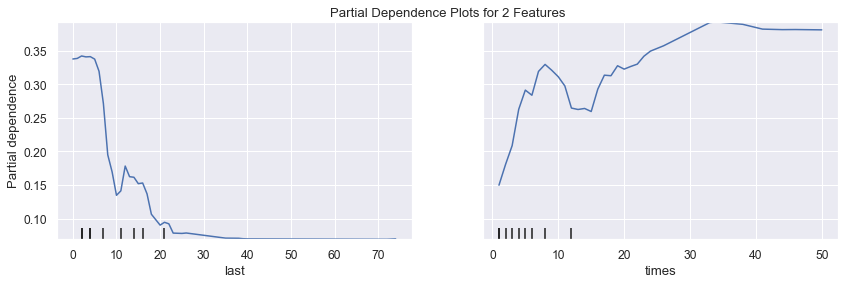

In [41]:
# Partial Dependence Plots
fig, ax = plt.subplots(figsize = (14, 4))
PartialDependenceDisplay.from_estimator(auc_pipeline, X,
                                        features = X.columns, ax = ax)
ax.set_title(f'Partial Dependence Plots for {len(X.columns)} Features')

### Recall Model

In [54]:
recall_pipeline = Pipeline([('scale', StandardScaler()),
                            ('knn', KNeighborsClassifier(n_neighbors = 1, weights = 'uniform'))])
recall_pipeline.fit(X_train, y_train)
recall_preds = recall_pipeline.predict(X_test)
recall_proba = recall_pipeline.predict_proba(X_test)

In [55]:
# recall decision boundary
recall_db = pd.DataFrame(
    {'threshold':thresholds,
     'accuracy' :[accuracy_score(y_test, np.where(recall_proba[:, 1] >= t, 1, 0) ) for t in thresholds],
     'precision':[precision_score(y_test, np.where(recall_proba[:, 1] >= t, 1, 0),
                                  pos_label=1, zero_division=0) for t in thresholds],
     'recall'   :[recall_score(y_test, np.where(recall_proba[:, 1] >= t, 1, 0),
                               pos_label=1, zero_division=0) for t in thresholds]
    })

In [63]:
recall_db

,threshold,accuracy,precision,recall
0,0.0,0.240642,0.240642,1.0
1,0.1,0.663102,0.250000,0.2
2,0.2,0.663102,0.250000,0.2
3,0.3,0.663102,0.250000,0.2
4,0.4,0.663102,0.250000,0.2
5,0.5,0.663102,0.250000,0.2
6,0.6,0.663102,0.250000,0.2
7,0.7,0.663102,0.250000,0.2
8,0.8,0.663102,0.250000,0.2
9,0.9,0.663102,0.250000,0.2


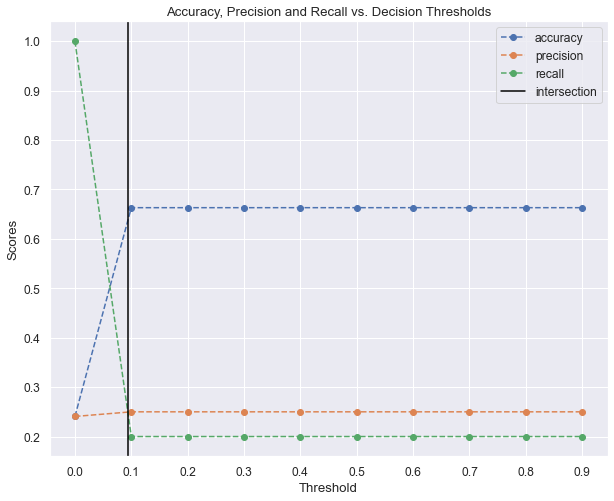

In [61]:

plt.subplots(figsize=(10,8))
plt.plot(recall_db['threshold'], recall_db['accuracy'], '--o', label = 'accuracy')
plt.plot(recall_db['threshold'], recall_db['precision'], '--o', label = 'precision')
plt.plot(recall_db['threshold'], recall_db['recall'], '--o', label = 'recall')
plt.axvline(x=0.095, color="black", label = 'intersection')
plt.xticks(thresholds)
plt.xlabel('Threshold')
plt.ylabel('Scores')
plt.title('Accuracy, Precision and Recall vs. Decision Thresholds')
plt.legend()
plt.grid(True)

[0. 1.]


Text(0.5, 1.0, 'Precision vs Recall')

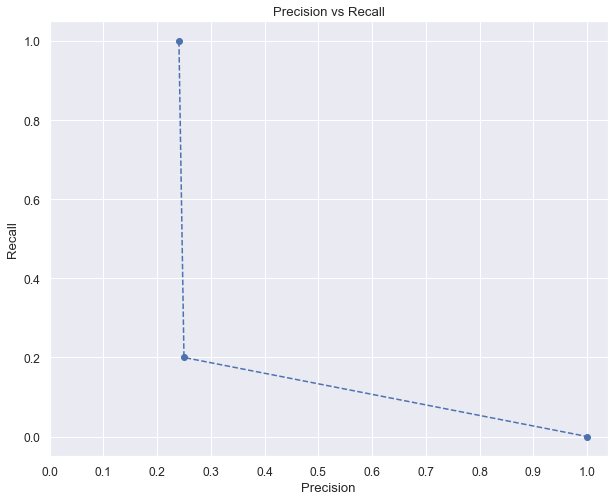

In [62]:
# Precision vs Recall
precision, recall, boundaries = precision_recall_curve(y_true = y_test,
                                                       probas_pred=recall_proba[:, 1], pos_label=1)

# 
print(boundaries[:5])
plt.subplots(figsize=(10,8))
plt.plot(precision, recall, '--o')
plt.xticks(np.arange(0, 1.1, .1))
plt.grid(True)
plt.ylabel('Recall')
plt.xlabel('Precision')
plt.title('Precision vs Recall')

In [65]:
# decision boundaries - n_neighbors = 1 will not make difference!
low_preds = np.where(recall_proba[:, 1] > .1, 1, 0)
high_preds = np.where(recall_proba[:, 1] > .6, 1, 0)

print(sum((~low_preds) & y_test), sum(~recall_preds & y_test), sum(~high_preds & y_test))

36 36 36


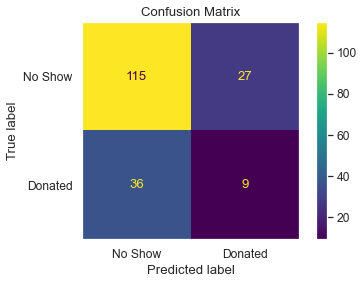

In [66]:
# check confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, recall_preds, display_labels = ['No Show', 'Donated'])
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Accuracy Model

In [49]:
accuracy_pipeline = Pipeline([('scale', StandardScaler()),
                               ('knn', KNeighborsClassifier(n_neighbors = 17, weights = 'uniform'))])
accuracy_pipeline.fit(X_train, y_train)
accuracy_preds = accuracy_pipeline.predict(X_test)

### Precision Model

In [46]:
# go with precision
precision_pipeline = Pipeline([('scale', StandardScaler()),
                               ('knn', KNeighborsClassifier(n_neighbors = 71, weights = 'uniform'))])
precision_pipeline.fit(X_train, y_train)
precision_preds = precision_pipeline.predict(X_test)

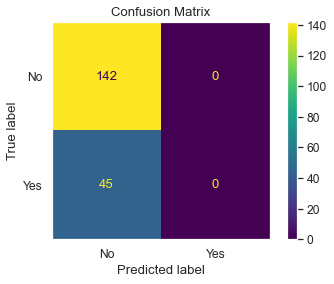

In [47]:
ConfusionMatrixDisplay.from_predictions(y_test, precision_preds, display_labels = ['No', 'Yes'])
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

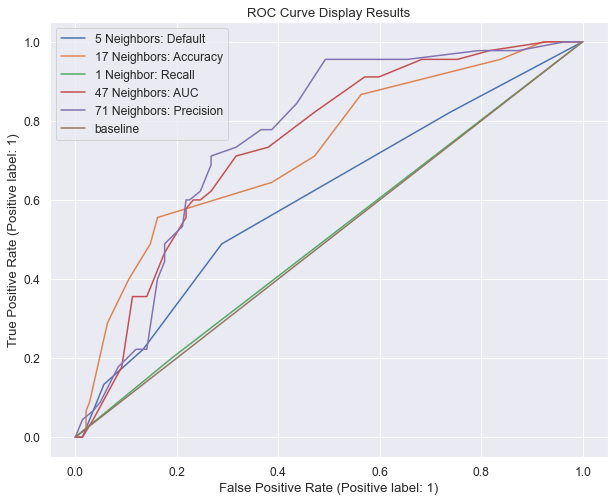

In [67]:
""" Plot ROC Curve 12.6
"""
fig, ax = plt.subplots(figsize=(10,8))
RocCurveDisplay.from_estimator(blood_pipeline, X_test, y_test, pos_label = 1, ax = ax, label = '5 Neighbors: Default')
RocCurveDisplay.from_estimator(accuracy_pipeline, X_test, y_test, pos_label = 1, ax = ax, label = '17 Neighbors: Accuracy')
RocCurveDisplay.from_estimator(recall_pipeline, X_test, y_test, pos_label = 1, ax = ax, label = '1 Neighbor: Recall')
RocCurveDisplay.from_estimator(auc_pipeline, X_test, y_test, pos_label = 1, ax = ax, label = '47 Neighbors: AUC')
RocCurveDisplay.from_estimator(precision_pipeline, X_test, y_test, ax = ax, label = '71 Neighbors: Precision')
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline')
plt.title('ROC Curve Display Results')
plt.legend()
plt.grid(True)

In [45]:
""" Build three classification metrics -- accuracy, precision, and recall with decision threshold
plot them in a graph
"""


' Build three classification metrics -- accuracy, precision, and recall with decision threshold\nplot them in a graph\n'